In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

In [3]:
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [10]:
#find most recent day and convert it a string which can be fed as an argument later
most_recent_day = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_day_string = most_recent_day[0]  # Extract the date string from the tuple

# Remove unnecessary characters from the string
most_recent_day_string = most_recent_day_string.strip("(),'")
print(most_recent_day_string)


2017-08-23


In [11]:
#turn the string into a Datetime Object
most_recent_date = dt.strptime(most_recent_day_string, '%Y-%m-%d').date()
print(most_recent_date)


2017-08-23


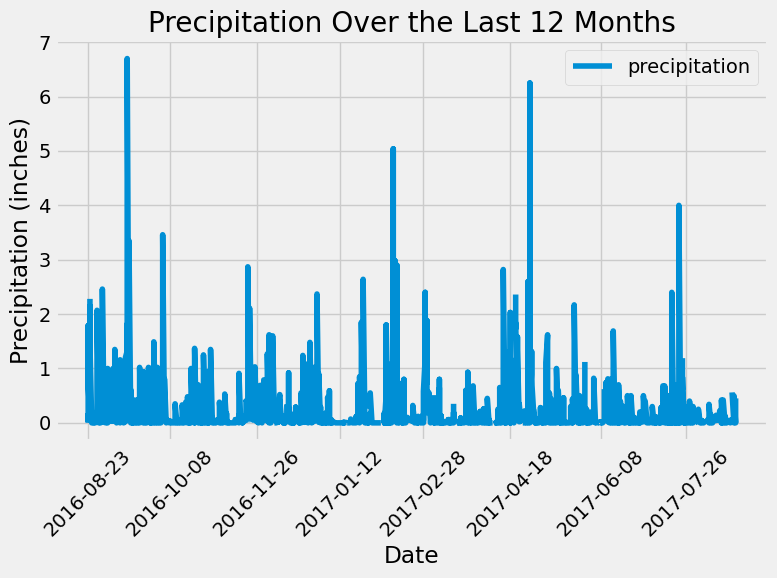

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(measurement.date, measurement.prcp) \
                 .filter(measurement.date >= one_year_ago) \
                 .filter(measurement.date <= most_recent_date) \
                 .order_by(measurement.date.asc()) \
                 .all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
# Done in results

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 6))
plt.plot(precip_df['date'], precip_df['precipitation'], label='precipitation')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(precip_df['date'][::300], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.name)).scalar()
total_stations

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)) \
                         .group_by(measurement.station) \
                         .order_by(func.count(measurement.station).desc()) \
                         .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_stats = session.query(func.min(measurement.tobs).label('lowest_temperature'),
                                 func.max(measurement.tobs).label('highest_temperature'),
                                 func.avg(measurement.tobs).label('average_temperature')) \
                           .filter(measurement.station == most_active_station_id) \
                           .first()
temperature_stats

(54.0, 85.0, 71.66378066378067)

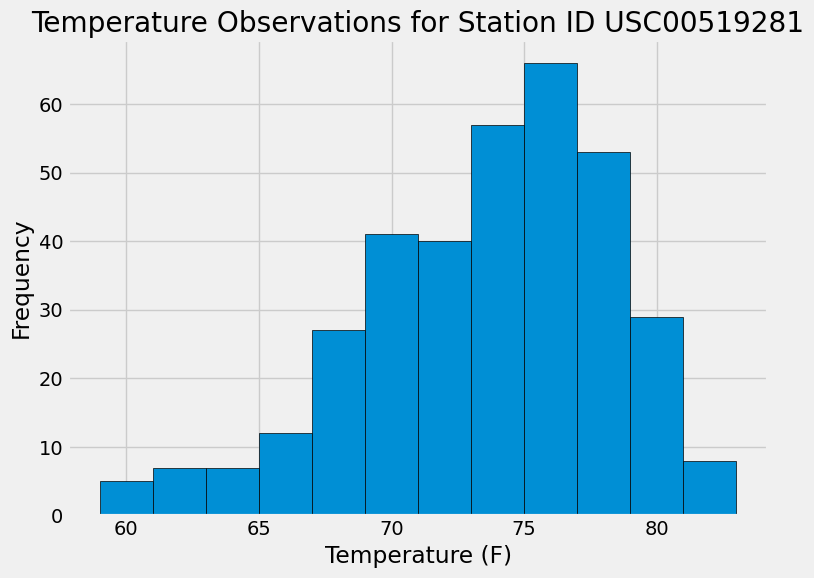

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#use date cariable from first section


# Query to retrieve the last 12 months of temperature data for the most active station
results = session.query(measurement.tobs) \
                 .filter(measurement.station == most_active_station_id) \
                 .filter(measurement.date >= one_year_ago) \
                 .filter(measurement.date <= most_recent_date) \
                 .all()

# Convert the query results into a list of temperatures
temperatures = [result[0] for result in results]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station ID {most_active_station_id}')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()